In [47]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

#!pip install torchsummary
from torchsummary import summary

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [49]:
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

In [50]:
torch.manual_seed(0)

def normalize(data_tensor):
    '''re-scale image values to [-1, 1]'''
    return (data_tensor / 255.) * 2. - 1.

transform_list = [transforms.ToTensor(
), transforms.Lambda(lambda x: normalize(x))]

train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.Compose(transform_list+[
                                               transforms.ToPILImage(),
                                               transforms.ToTensor(),
                                               ]),
                                           download=True)


test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.Compose(transform_list+[
                                              transforms.ToPILImage(),
                                              transforms.ToTensor(),
                                              
                                          ]))

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

Train data set: 60000
Test data set: 10000


In [51]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.non_linearity1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.non_linearity2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.max_pool1(x)
        x = self.non_linearity1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.max_pool2(x)
        x = self.non_linearity2(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [52]:
model = ConvNet(num_classes).to(device)
model

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (non_linearity2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [53]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
       BatchNorm2d-2           [-1, 16, 30, 30]              32
         MaxPool2d-3           [-1, 16, 15, 15]               0
              ReLU-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 32, 17, 17]           4,640
       BatchNorm2d-6           [-1, 32, 17, 17]              64
         MaxPool2d-7             [-1, 32, 8, 8]               0
              ReLU-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 25,386
Trainable params: 25,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 0.10
Estimated Total Size (MB): 0.55
---------------------------------------------

In [54]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    l1_factor = 0.0001

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # compute loss
                    loss = criterion(outputs, labels)

                    # compute L1 loss component
                    l1_loss = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
                    reg_loss = 0 
                    for param in model.parameters():
                        zero_vector = torch.rand_like(param) * 0
                        reg_loss += l1_loss(param, zero_vector)
      
                    # add L2 loss component
                    loss += reg_loss * l1_factor

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [55]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

dataloaders = dict(train=train_loader, val=valid_loader)

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=10, log_interval=1)


Total number of parameters = 25386
Epoch 0/9
----------
train Loss: 0.2622 Acc: 0.92513
val Loss: 13.5253 Acc: 0.22229

Epoch 1/9
----------
train Loss: 0.0790 Acc: 0.97674
val Loss: 8.4707 Acc: 0.18146

Epoch 2/9
----------
train Loss: 0.0581 Acc: 0.98227
val Loss: 0.0947 Acc: 0.97083

Epoch 3/9
----------
train Loss: 0.0454 Acc: 0.98565
val Loss: 0.0800 Acc: 0.97667

Epoch 4/9
----------
train Loss: 0.0377 Acc: 0.98875
val Loss: 0.0984 Acc: 0.97125

Epoch 5/9
----------
train Loss: 0.0334 Acc: 0.98878
val Loss: 0.1004 Acc: 0.96906

Epoch 6/9
----------
train Loss: 0.0283 Acc: 0.99089
val Loss: 1.1202 Acc: 0.76292

Epoch 7/9
----------
train Loss: 0.0257 Acc: 0.99164
val Loss: 0.0819 Acc: 0.97677

Epoch 8/9
----------
train Loss: 0.0193 Acc: 0.99393
val Loss: 0.1016 Acc: 0.97021

Epoch 9/9
----------
train Loss: 0.0203 Acc: 0.99362
val Loss: 0.0655 Acc: 0.98219

Training complete in 2m 6s
Best val Acc: 0.98219


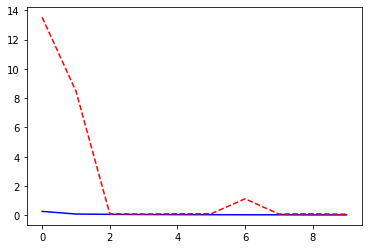

In [56]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [57]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.98310 
